In [7]:
%pylab inline

# Import our plot library
from vplot import *

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from matplotlib.patches import Polygon
import scipy.stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
import re

# Libraries from eSTR viz notebook
import statsmodels.api as sm
import seaborn.apionly as sns
import statsmodels.formula.api as smf

SIMDIR="/storage/ileena/simulation/SSC/fig_haplo_paper/"
DATADIR="/storage/mgymrek/ssc-imputation/"
OUTPATH="pdfs/"
PREFIX="Figure4"

Populating the interactive namespace from numpy and matplotlib


/usr/lib64/python3.4/importlib/_bootstrap.py:321: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  return f(*args, **kwds)


In [71]:
# Functions for plotting

def PlotExample(ex_data, fname, color="black"):
    lw=1
    boxprops = dict(color=color, linewidth=lw)
    medianprops = dict(color=color, linewidth=lw)
    fig = plt.figure()
    fig.set_size_inches((6, 4))
    ax = fig.add_subplot(111)
    bp = ex_data.boxplot(column="pt", by="gt", ax=ax, grid=False, boxprops=boxprops, medianprops=medianprops,
                return_type='dict');

    [[item.set_linewidth(lw) for item in bp[key]['boxes']] for key in bp.keys()]
    [[item.set_linewidth(lw) for item in bp[key]['fliers']] for key in bp.keys()]
    [[item.set_linewidth(lw) for item in bp[key]['medians']] for key in bp.keys()]
    [[item.set_linewidth(lw) for item in bp[key]['means']] for key in bp.keys()]
    [[item.set_linewidth(lw) for item in bp[key]['whiskers']] for key in bp.keys()]
    [[item.set_linewidth(lw) for item in bp[key]['caps']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['boxes']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['fliers']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['medians']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['whiskers']] for key in bp.keys()]
    [[item.set_color(color) for item in bp[key]['caps']] for key in bp.keys()]

    ax.set_title("")
    plt.suptitle("");
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.set_xlabel("STR Genotype (bp relative to hg19)", size=20)
    ax.set_ylabel("Simulated phenotype", size=20);
    ax.set_xticklabels(ax.get_xticklabels(), size=15);
    ax.set_yticks(np.arange(-3, 3.1, 1))
    ax.set_yticklabels(ax.get_yticks(), size=15);
    fig.savefig(fname)
    
def PlotR2Pval(r2, assoc, fname):
    # Pull out SNPs
    str_coord = assoc[assoc["testclass"]=="STR"]["locus"].values[0]
    r2 = r2[r2["locus1"]==str_coord]
    r2["locus"] = r2["locus2"]
    snp_assoc = assoc[assoc["testclass"]=="SNP"]
    snp_assoc = pd.merge(snp_assoc, r2, on=["locus"])

    fig = plt.figure()
    fig.set_size_inches((6, 4))
    ax = fig.add_subplot(111)
    # Plotting all SNPs
    ax.scatter(snp_assoc["r2"], snp_assoc["pvalue"].apply(lambda x: -1*np.log10(x)), color="gray", s=8, label="SNPs");
    # Plot the STR
    ax.scatter([1.0], [assoc[assoc["testclass"]=="STR"]["pvalue"].apply(lambda x: -1*np.log10(x)).values[0]], color="red", s=40, label="STR")
    # Plot the imputed STR
    imp_ld = r2_imp[r2_imp["locus1"]==str_coord]["r2"].values[0]
    imp_p = assoc[assoc["testclass"]=="IMPSTR"]["pvalue"].apply(lambda x: -1*np.log10(x)).values[0]
    ax.scatter([imp_ld], [imp_p], color="blue", s=40, label="Imputed STR");
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    ax.set_xlabel("R2 with causal STR", size=15)
    ax.set_ylabel("-log10 P", size=15);
    ax.set_xticklabels(["%.1f"%x for x in ax.get_xticks()], size=12)
    ax.set_yticklabels(["%.1f"%x for x in ax.get_yticks()], size=12)
    ax.legend(loc="upper left");
    fig.savefig(fname)
    
def GetPower(x, alpha=0.05):
    return np.mean([(int(float(item) < alpha)) for item in x])

def PlotPower(assoc, fname, alpha=0.05):
    # Calculate power for each class
    assoc_tmp = assoc.groupby(["str","testclass"], as_index=False).agg({"pvalue": lambda x: GetPower(x)})
    assoc_tmp["power"] = assoc_tmp["pvalue"]
    assoc_tmp = assoc_tmp[["str","testclass","power"]]
    impdata = assoc_tmp[assoc_tmp["testclass"]=="IMPSTR"].copy()
    snpdata = assoc_tmp[assoc_tmp["testclass"]=="SNP"].copy()
    strdata = assoc_tmp[assoc_tmp["testclass"]=="STR"].copy()
    impdata["imp_power"] = impdata["power"]
    snpdata["snp_power"] = snpdata["power"]
    strdata["str_power"] = strdata["power"]
    power = pd.merge(impdata[["str","imp_power"]], snpdata[["str", "snp_power"]], on=["str"])
    power = pd.merge(power, strdata[["str","str_power"]], on=["str"])
    power["powerdiff"] = power["imp_power"] - power["snp_power"]
    power["locus"] = power["str"]
    data = pd.merge(power, r2comp, on=["locus"])
    g = sns.jointplot(x="r2diff", y="powerdiff", data=data, color="black", edgecolor="black")
    g.ax_joint.axvline(x=0, linestyle="dashed", color="gray")
    g.ax_joint.axhline(y=0, linestyle="dashed", color="gray")
    g.ax_joint.set_xlabel("r2imp-r2bestsnp", size=15)
    g.ax_joint.set_ylabel("powerimp-powerbestsnp", size=15)
    g.savefig(fname)
    print(data.shape[0])
    print(np.mean(data["r2diff"]))
    print(np.mean(data["powerdiff"]))

In [63]:
# Load LD values
r2_snp = pd.read_csv(os.path.join(DATADIR, "gwas-power", "r2_snp.tab"), sep="\t")
r2_imp = pd.read_csv(os.path.join(DATADIR, "gwas-power", "r2_imp.tab"), sep="\t")
best_snp = r2_snp.groupby("locus1", as_index=False).agg({"r2": max, "freq_het": np.mean})
r2comp = pd.merge(best_snp, r2_imp, on=["locus1"])[["locus1","freq_het_x","r2_x","r2_y"]]
r2comp.columns = ["locus","het","r2_bestsnp","r2_ssc"]
r2comp["r2diff"] = r2comp["r2_ssc"]-r2comp["r2_bestsnp"]

# Figure 3

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2106
0.17671083911799743
0.11093542260208927


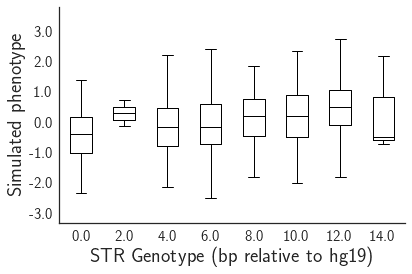

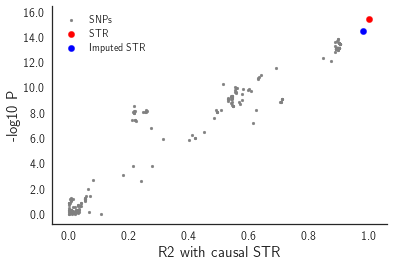

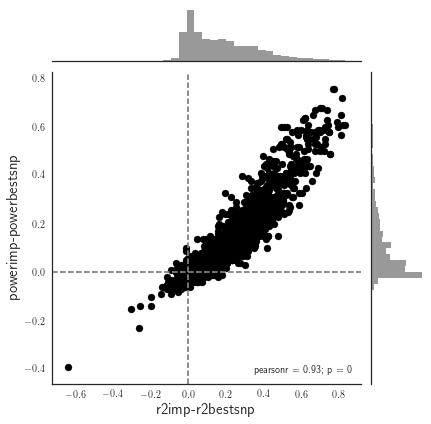

In [72]:
# Load data for quant
ex_gt_data = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_quant_example.gt"), sep="\t")
ex_pt_data = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_quant_example_0.pheno"), sep="\t", names=["Sample_ID", "x", "pt"])
ex_data = pd.merge(ex_gt_data, ex_pt_data, on=["Sample_ID"])
ex_data["gt"] = ex_data["True_STR_Sum"]
exassoc = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_quant_example_power_simulation_results.txt"), sep="\t")
assoc = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_casecontrol.tab_power_simulation_results.txt"), sep="\t")


PlotExample(ex_data, os.path.join(OUTPATH, "%s_ExampleAssociation.pdf"%PREFIX))
PlotR2Pval(r2, exassoc, os.path.join(OUTPATH, "%s_r2vsP.pdf"%PREFIX))
PlotPower(assoc, os.path.join(OUTPATH, "%s_GWASPowerQuant.pdf"%PREFIX), alpha=0.05)

In [73]:
# Mean gain in r2 vs. num alleles
sscloo = pd.read_csv(os.path.join(DATADIR, "loo","l1o.results.csv"))
sscloo["locus"] = sscloo["str"]
ldata = pd.merge(sscloo, r2comp, on=["locus"])
print(np.mean(ldata[(ldata["numAllele"]>=3)]["r2diff"]))
print(np.mean(ldata["r2diff"]))

0.19854779050575735
0.18531421973605547


# Supplementary Figure: case/control

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2690
0.17935322662001393
0.05051329230576989


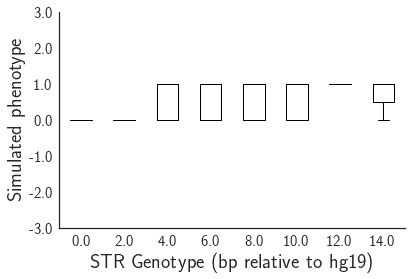

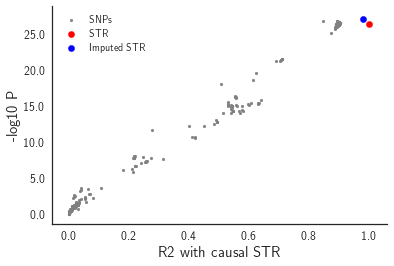

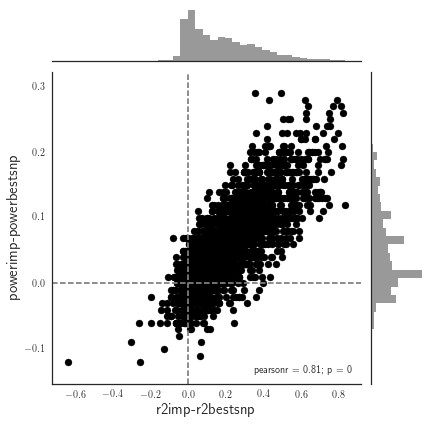

In [86]:
# Load data for case/control
exp_gt_data = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_cc_example.gt"), sep="\t")
exp_pt_data = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_cc_example_0.pheno"), sep="\t", names=["Sample_ID", "x", "pt"])
ex_data = pd.merge(exp_gt_data, exp_pt_data, on=["Sample_ID"])
ex_data["gt"] = ex_data["True_STR_Sum"]
exassoc = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_cc_example_power_simulation_results.txt"), sep="\t")
assoc = pd.read_csv(os.path.join(DATADIR, "gwas-power", "snpstr_power_sims_casecontrol.tab_power_simulation_results.txt"), sep="\t")

PlotExample(ex_data, os.path.join(OUTPATH, "SuppFig_ExampleAssociation.pdf"))
PlotR2Pval(r2, exassoc, os.path.join(OUTPATH, "SuppFig_r2vsP.pdf"))
PlotPower(assoc, os.path.join(OUTPATH, "SuppFig_GWASPowerCC.pdf"), alpha=0.05)

# Supplementary Figure: r2imp-r2best vs. num alleles

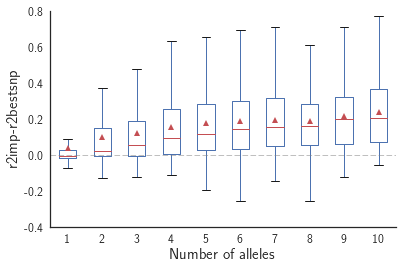

In [7]:
fig = plt.figure()
fig.set_size_inches((6, 4))
ax = fig.add_subplot(111)
ldata[ldata["numAllele"]<=10].boxplot(column="r2diff", by="numAllele", grid=False, ax=ax, showmeans=True);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom');
ax.axhline(y=0, linestyle="dashed", color="gray", linewidth=0.5)
ax.set_ylim(bottom=-0.4, top=0.8)
ax.set_title("")
plt.suptitle("")
ax.set_xlabel("Number of alleles", size=15)
ax.set_ylabel("r2imp-r2bestsnp", size=15)
ax.set_xticklabels(ax.get_xticks(), size=12)
ax.set_yticklabels(["%.1f"%x for x in ax.get_yticks()], size=12);
fig.savefig(os.path.join(OUTPATH, "SuppFig_r2gain.pdf"))

In [2]:
def gen_scatter(X, Y, outputFileName=None, marker='.', color='gray', label='_nolegend_', xlabel="X-Label", ylabel="Y-Label", xlim=None, ylim=None, xticksFormat=None, yticksFormat=None, diagonal=False, lr=False, legend=False, alpha=None, empty=False):
    fig = plt.figure()
    ax=fig.add_subplot(111)
    
    if empty is True:
        X = [np.min(X), np.max(X)]
        Y = [np.min(Y), np.max(Y)]
    
    ax.scatter(X, Y, marker=marker, color=color, label=label, alpha=alpha)
    ax.set_xlabel(xlabel, size=15)
    ax.set_ylabel(ylabel, size=15)

    if diagonal is True:
        ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle="dashed", color="black", label="Diagonal")
    
    if xlim is not None:
        ax.set_xlim(xlim)
        
    if ylim is not None:
        ax.set_ylim(ylim)
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    if lr is True:
        m,b=np.polyfit(X, Y, 1)
        X_plot=np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
        ax.plot(X_plot, m*X_plot+b, linestyle="dashed", color="blue", label="Best fit")

    ax.set_xticklabels(ax.get_xticks(), size=12);
    ax.set_yticklabels(ax.get_yticks(), size=12);
    
    if xticksFormat is not None:
        ax.set_xticklabels([xticksFormat%(x) for x in ax.get_xticks()], size=10);
    if yticksFormat is not None:
        ax.set_yticklabels([yticksFormat%(x) for x in ax.get_yticks()], size=12);
    
    if legend is True:
        legend = ax.legend(loc="upper center")
        
    if outputFileName is not None:
        fig.savefig(outputFileName)
    print(scipy.stats.pearsonr(X,Y))

In [3]:
def gen_qq(pval1, pval2=None, outputFileName=None, marker='.', color1='red', color2 = "blue", label1='_nolegend_', label2='_nolegend_', xlabel="Expected Values (-log10)", ylabel="Observed Values (-log10)", xlim=None, ylim=None, xticksFormat=None, yticksFormat=None, diagonal=False, lr=False, legend=False, alpha=None, empty=False):
    fig = plt.figure()
    ax=fig.add_subplot(111)
    
    Y = -1*np.log10(np.sort(pval1))
    X = -1*np.log10(1.0*np.array(range(len(Y)))/len(Y))
    
    if empty is True:
        X = [np.min(X), np.max(X)]
        Y = [np.min(Y), np.max(Y)]
    
    ax.scatter(X, Y, marker=marker, color=color1, label=label1, alpha=alpha)
    
    if pval2 is not None:
        Y_2 = -1*np.log10(np.sort(pval2))
        X_2 = -1*np.log10(1.0*np.array(range(len(Y_2)))/len(Y_2))
        ax.scatter(X_2, Y_2, marker=marker, color=color2, label=label2, alpha=alpha)
        
        
    ax.set_xlabel(xlabel, size=15)
    ax.set_ylabel(ylabel, size=15)

    if diagonal is True:
        ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle="dashed", color="black", label="Diagonal")
    
    if xlim is not None:
        ax.set_xlim(xlim)
        
    if ylim is not None:
        ax.set_ylim(ylim)
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    if lr is True:
        m,b=np.polyfit(X, Y, 1)
        X_plot=np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
        ax.plot(X_plot, m*X_plot+b, linestyle="dashed", color="blue", label="Best fit")

    ax.set_xticklabels(ax.get_xticks(), size=12);
    ax.set_yticklabels(ax.get_yticks(), size=12);
    
    if xticksFormat is not None:
        ax.set_xticklabels([xticksFormat%(x) for x in ax.get_xticks()], size=10);
    if yticksFormat is not None:
        ax.set_yticklabels([yticksFormat%(x) for x in ax.get_yticks()], size=12);
    
    if legend is True:
        legend = ax.legend(loc="best")
        
    if outputFileName is not None:
        fig.savefig(outputFileName)

In [5]:
min_col = 'qvalue'
chrom="21"
raw_values = pd.read_csv("/storage/s1saini/manuscript_strsnp/gtex/Non_imputed_PQvalues_SFF_chr"+chrom, delimiter="\t").drop(['str.id'], axis=1)
raw_values_id_to_pos = pd.read_csv("/storage/s1saini/manuscript_strsnp/gtex/chr"+chrom+"_pos_to_id_raw.txt", names=['str.start','str.id'], delim_whitespace=True)
raw_values = pd.merge(raw_values, raw_values_id_to_pos, on="str.start", how="inner")
sig_raw_values = raw_values[raw_values[min_col] < 0.1].reset_index()
sig_raw_values = sig_raw_values.iloc[sig_raw_values.groupby('gene').agg({min_col:'idxmin'})[min_col]]#[['gene','str.id', 'beta', min_col]]

imputed_values = pd.read_csv("/storage/s1saini/manuscript_strsnp/gtex/PQValues_47_chr"+chrom, delimiter="\t").drop(['str.id'], axis=1)
imputed_values_id_to_pos = pd.read_csv("/storage/s1saini/manuscript_strsnp/gtex/chr"+chrom+"_pos_to_id_imputed.txt", names=['str.start','str.id'], delim_whitespace=True)
imputed_values = pd.merge(imputed_values, imputed_values_id_to_pos, on="str.start", how="inner")

imputed_raw = pd.merge(sig_raw_values, imputed_values, how="inner", on=['gene','str.id'])
imputed_raw.head()

,index,gene,chrom_x,str.start_x,p.wald_x,llqvalue_x,llsignif_x,NTEST_x,qvalue_x,significant_x,...,chrom_y,str.start_y,p.wald_y,llqvalue_y,llsignif_y,NTEST_y,qvalue_y,significant_y,beta_y,beta.se_y
0,141,ENSG00000142156.10,chr21,47436409,1.566967e-08,0.000833,1,6.0,0.001756,1.0,...,chr21,47436409,2.998231e-06,0.003174,1,15.0,0.02591,1.0,0.299897,0.062631
1,200,ENSG00000142166.8,chr21,34740563,1.036883e-06,0.000833,1,22.0,0.001765,1.0,...,chr21,34740563,7.750065e-05,0.003392,1,NaN,NaN,NaN,-0.255420,0.063476
2,260,ENSG00000142168.10,chr21,32964604,3.579907e-04,0.010360,1,17.0,0.051333,1.0,...,chr21,32964604,2.249939e-02,0.141712,0,NaN,NaN,NaN,-0.149131,0.064919
3,239,ENSG00000142188.12,chr21,34814319,8.936800e-29,0.000833,1,17.0,0.001756,1.0,...,chr21,34814317,7.042982e-26,0.003174,1,NaN,NaN,NaN,-0.616397,0.051698
4,504,ENSG00000142197.8,chr21,37504210,1.782487e-06,0.000833,1,36.0,0.002018,1.0,...,chr21,37504210,8.244185e-05,0.003411,1,NaN,NaN,NaN,0.254494,0.063492


# Figure 3D - Effect Sizes

(0.4660907518847771, 0.0006464196152597942)


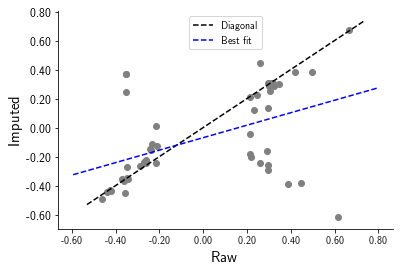

In [8]:
gen_scatter(imputed_raw['beta_x'], imputed_raw['beta_y'], xlabel="Raw", ylabel="Imputed", diagonal=True, lr=True, legend=True, marker="o", xticksFormat="%.2f", yticksFormat="%.2f")

# Figure 3E - QQ Plot

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in log10


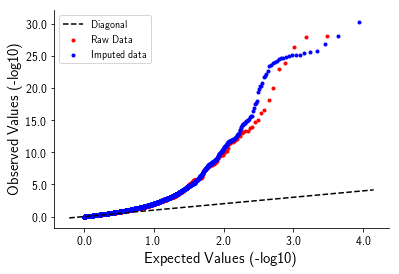

In [9]:
gen_qq(raw_values['p.wald'].values, imputed_values['p.wald'].values, label1 = "Raw Data", label2 = "Imputed data", legend = True, diagonal=True, marker=".")

# Figure 3F - Example Locus


In [10]:
# CSTB
CHROM=21
START=45196326
GENE="ENSG00000160213.5"

TISSUES="Nerve-Tibial"

## Raw genotypes

In [12]:
%%bash -s "$CHROM" "$START" "$TISSUES" "$GENE"

CHROM=$1
START=$2
TISSUES=$3
GENE=$4

VCF=/storage/szfeupe/Runs/650GTEx_estr/Merged_STRs_all_samples.vcf.gz 

# Pull out STR genotypes
bcftools query -r ${CHROM}:${START}-${START} -f"[%SAMPLE\t%GB\n]" $VCF | \
    grep -v "\." | sed 's/|/\t/' | awk '{print $1 "\t" $2+$3}' > str_genotypes.tab

# Pull out gene expression
for t in $(echo $TISSUES | sed 's/,/ /g')
do
    EXPR=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/${t}/Corr_Expr.csv
    colnum=$(cat $EXPR | head -n 1 | sed 's/,/\t/g' | datamash transpose | awk '{print NR "\t" $0}' | grep -w $GENE | cut -f 1)
    cat $EXPR | cut -d',' -f 1,$((${colnum}+1)) | grep -v ENSG > expr_${t}.tab
done

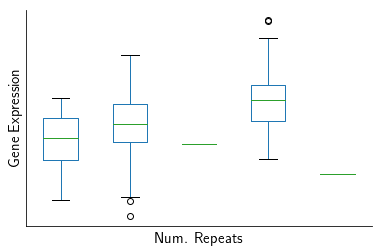

In [13]:
strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))

# Plot single tissue
fig = plt.figure()
ax = fig.add_subplot(111)
t="Nerve-Tibial"
expr = pd.read_csv("expr_%s.tab"%t, names=["sample","expr"])
data = pd.merge(strgt, expr)
data.boxplot(column="expr", by="str", ax=ax, grid=False);
ax.set_xlabel("Num. Repeats", size=15)
ax.set_ylabel("Gene Expression", size=15)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.suptitle("");
plt.show()
fig.savefig("example_estr.pdf")

## Imputed genotypes


In [15]:
%%bash -s "$CHROM" "$START" "$TISSUES" "$GENE"

CHROM=$1
START=$2
TISSUES=$3
GENE=$4

VCF=/storage/s1saini/manuscript_strsnp/gtex/gtex_beagle41_chr21_multiallelic.vcf.gz

# Pull out STR genotypes
bcftools query -r ${CHROM}:${START}-${START} -f"[%SAMPLE\t%REF\t%TGT\n]" $VCF | \
    grep -v "\." > str_genotypes.tab

# Pull out gene expression
for t in $(echo $TISSUES | sed 's/,/ /g')
do
    EXPR=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/${t}/Corr_Expr.csv
    colnum=$(cat $EXPR | head -n 1 | sed 's/,/\t/g' | datamash transpose | awk '{print NR "\t" $0}' | grep -w $GENE | cut -f 1)
    cat $EXPR | cut -d',' -f 1,$((${colnum}+1)) | grep -v ENSG > expr_${t}.tab
done

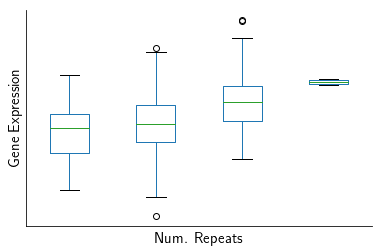

In [16]:
strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","ref","str"])
strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))

sample_gt = list()
for i in strgt.values:
    refLen = len(i[1])
    gt_bases = re.split('/|\|',i[2])
    if ('.' in gt_bases):
        gt_bases_len = 'NA'
    else:
        gt_bases_len = np.sum([(len(j) - refLen) for j in gt_bases])
    sample_gt.append([i[0], gt_bases_len])
    
strgt = pd.DataFrame.from_records(sample_gt, columns=['sample','str'])

# Plot single tissue
fig = plt.figure()
ax = fig.add_subplot(111)
t="Nerve-Tibial"
expr = pd.read_csv("expr_%s.tab"%t, names=["sample","expr"])
data = pd.merge(strgt, expr)
data.boxplot(column="expr", by="str", ax=ax, grid=False);
ax.set_xlabel("Num. Repeats", size=15)
ax.set_ylabel("Gene Expression", size=15)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.suptitle("");
plt.show()
fig.savefig("example_estr.pdf")

## Best tag snp

In [18]:
# CSTB
CHROM=21
START=45201832

In [19]:
%%bash -s "$CHROM" "$START" "$TISSUES" "$GENE"

CHROM=$1
START=$2
TISSUES=$3
GENE=$4

VCF=/storage/s1saini/manuscript_strsnp/gtex/gtex_beagle41_chr21.vcf.gz

# Pull out STR genotypes
bcftools query -r ${CHROM}:${START}-${START} -f"[%SAMPLE\t%GT\n]" $VCF | \
    grep -v "\." | sed 's/|/\t/' | awk '{print $1 "\t" $2+$3}' > str_genotypes.tab

# Pull out gene expression
for t in $(echo $TISSUES | sed 's/,/ /g')
do
    EXPR=/storage/szfeupe/Runs/650GTEx_estr/Analysis_by_Tissue/${t}/Corr_Expr.csv
    colnum=$(cat $EXPR | head -n 1 | sed 's/,/\t/g' | datamash transpose | awk '{print NR "\t" $0}' | grep -w $GENE | cut -f 1)
    cat $EXPR | cut -d',' -f 1,$((${colnum}+1)) | grep -v ENSG > expr_${t}.tab
done

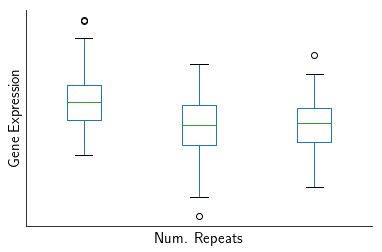

In [20]:
strgt = pd.read_csv("str_genotypes.tab", sep="\t", names=["sample","str"])
strgt["sample"] = strgt["sample"].apply(lambda x: "-".join(x.split("-")[0:2]))

# Plot single tissue
fig = plt.figure()
ax = fig.add_subplot(111)
t="Nerve-Tibial"
expr = pd.read_csv("expr_%s.tab"%t, names=["sample","expr"])
data = pd.merge(strgt, expr)
data.boxplot(column="expr", by="str", ax=ax, grid=False);
ax.set_xlabel("Num. Repeats", size=15)
ax.set_ylabel("Gene Expression", size=15)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.suptitle("");
plt.show()
fig.savefig("example_estr.pdf")